# ESAME DI TECNICHE DI RAPPRESENTAZIONE E MODELLIZZAZIONE DEI DATI

## Studio del profilo di densità NFW e stima della massa e della concentrazione di aloni di materia oscura

Il progetto ha lo scopo di stimare i parametri fisici degli aloni di materia oscura (massa e concentrazione) a partire da simulazioni cosmologiche. Il metodo si basa sulla modellizzazione analitica del profilo di densità proiettato (NFW), l'analisi statistica dei dati simulati, e l'uso di tecniche di inferenza bayesiana tramite MCMC (`emcee`).

Il codice è strutturato in **quattro parti**:
1. **Modello analitico del profilo NFW (2D)**
2. **Analisi dei dati simulati con binning per ricchezza**
3. **Stima dei parametri con campionamento MCMC**
4. **Valutazione dei risultati: fit, intervalli di confidenza, $\chi^2$**


## PARTE A: Modello Analitico 2D del Profilo NFW

In questa sezione si definisce un modello teorico del profilo di densità proiettato degli aloni secondo la formulazione NFW.  
Viene costruita una classe `Density` che calcola i parametri caratteristici (raggio di scala $r_s$, densità caratteristica $\rho_s$) e la funzione $\Sigma(R,M,c,z)$.

Si producono dei grafici che mostrano il comportamento del profilo $\Sigma$ al variare della massa totale dell'alone e della concentrazione.


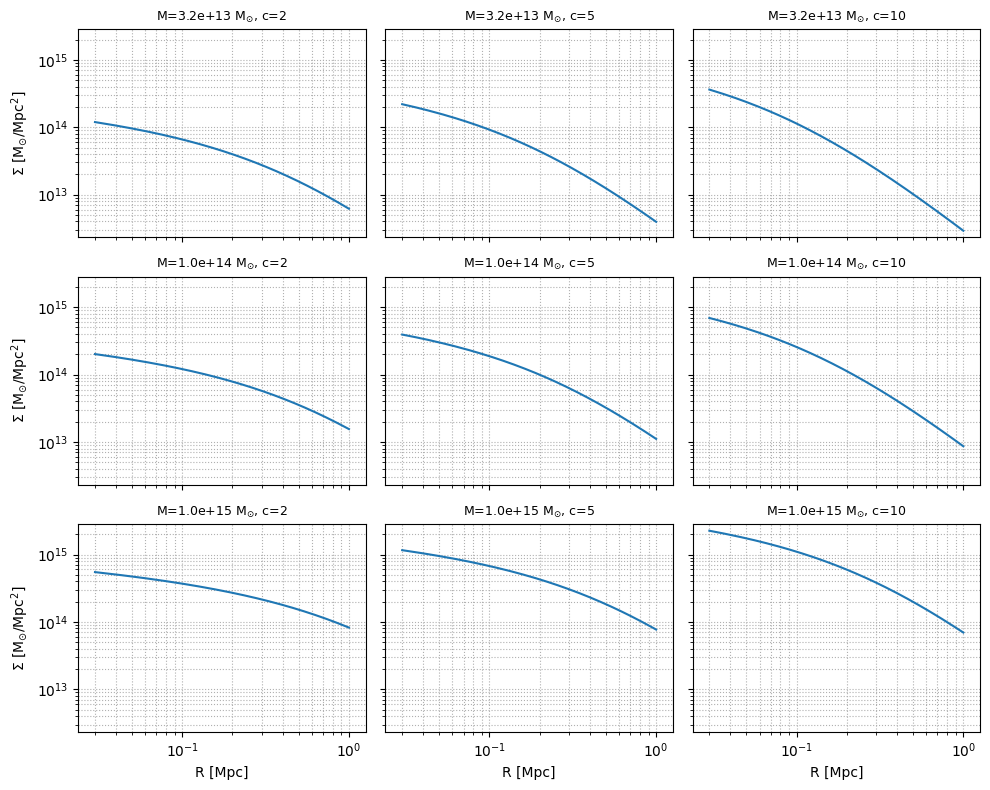

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import emcee
import corner
import pandas as pd
# Cosmology‐related constant (in M☉/Mpc³)
RU = 0.286 * 0.7**2 * 2.7751428946e11

def compute_rs(M, c, z=0.0):
    rhom = RU * (1 + z)**3
    return (3 * M / (4 * np.pi * 200 * rhom))**(1/3) / c

def compute_rhos(M, c, z=0.0):
    fc = np.log(1 + c) - c/(1 + c)
    delta_char = 200 * c**3 / (3 * fc)
    rhom = RU * (1 + z)**3
    return rhom * delta_char

def proj_nfw_sigma(R, M, c, z=0.0):
    rs   = compute_rs(M, c, z)
    rhos = compute_rhos(M, c, z)
    x = R / rs

    y = np.zeros_like(x)
    m1, m2, m3 = x < 1, x == 1, x > 1
    y[m1] = (1/(x[m1]**2 - 1) *(1 - 2/np.sqrt(1 - x[m1]**2) * np.arctanh(np.sqrt((1 - x[m1])/(1 + x[m1])))))
    y[m2] = 1/3
    y[m3] = (1/(x[m3]**2 - 1) *(1 - 2/np.sqrt(x[m3]**2 - 1) * np.arctan(np.sqrt((x[m3] - 1)/(x[m3] + 1)))))
    return 2 * rs * rhos * y

# Parameters
M_vals = [10**13.5, 10**14, 10**15]
c_vals = [2, 5, 10]
R_ana  = np.linspace(0.03, 1.0, 300)

# Pre-compute all profiles
all_sigmas = [proj_nfw_sigma(R_ana, M, c) for M in M_vals for c in c_vals]
ymin, ymax = min(s.min() for s in all_sigmas), max(s.max() for s in all_sigmas)
xmin, xmax = R_ana.min(), R_ana.max()

# pad by 10% in log‐space
pad_frac = 0.1
x_plot_min = xmin * 10**(-pad_frac)
x_plot_max = xmax * 10**( pad_frac)
y_plot_min = ymin * 10**(-pad_frac)
y_plot_max = ymax * 10**( pad_frac)

fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True)
for i, M in enumerate(M_vals):
    for j, c in enumerate(c_vals):
        Σ = proj_nfw_sigma(R_ana, M, c)
        ax = axes[i, j]
        ax.loglog(R_ana, Σ, lw=1.5)
        
        # mark and label the first/last points
        
            
        ax.set_title(f"M={M:.1e} M$_⊙$, c={c}", fontsize=9)
        ax.grid(True, which='both', ls=':')
        ax.set_xlim(x_plot_min, x_plot_max)
        ax.set_ylim(y_plot_min, y_plot_max)
        if i == 2: ax.set_xlabel("R [Mpc]")
        if j == 0: ax.set_ylabel("Σ [M$_⊙$/Mpc$^2$]")


fig.tight_layout()

## PARTE B: Dati Simulati, Binning e Analisi Statistica

In questa parte si caricano i dati provenienti da simulazioni cosmologiche (`halo_catalog.fit`) e si suddividono gli aloni in 5 gruppi (bin) in base alla loro ricchezza (`λ`, direttamente correlata alla massa totale dell'alone).  
Per ciascun gruppo si calcola il profilo medio di densità proiettata `Σ(R)` e la sua deviazione standard.  
I risultati vengono rappresentati con barre di errore e confrontati con un modello NFW tratteggiato.


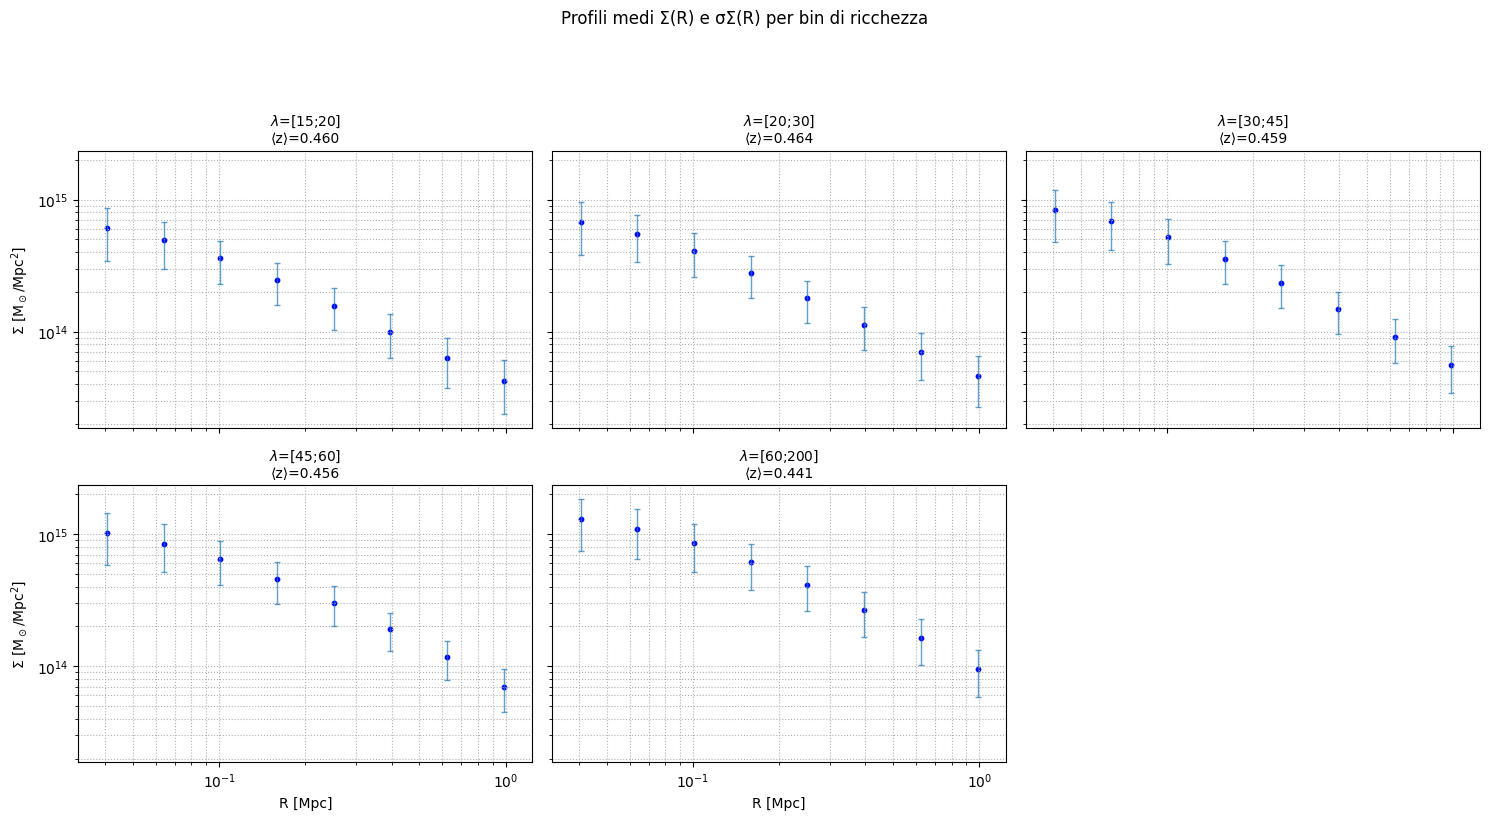

In [31]:

from astropy.table import Table

# 1) LOAD DATA
tbl     = Table.read("halo_catalog.fit")      # columns: 'Z', 'LAMBDA_TR', 'SIGMA_of_R'
R       = np.load("R_values.npy")              # shape (N_R,)
z       = np.array(tbl["Z"])                   # (N_halos,)
rich    = np.array(tbl["LAMBDA_TR"])            # (N_halos,)
sigma   = np.array(tbl["SIGMA_of_R"])           # (N_halos, N_R)

# 2) DEFINE RICHNESS BINS
lambda_edges = [15, 20, 30, 45, 60, 200]
n_bins       = len(lambda_edges) - 1

# 3) FOR EACH BIN, COMPUTE ⟨z⟩, σ_z, ⟨Σ⟩(R), σ_Σ(R)
mean_z      = []
std_z       = []
mean_sigmas = []
std_sigmas  = []

for i in range(n_bins):
    low, high = lambda_edges[i], lambda_edges[i+1]
    # include ≤ high on the last bin
    if i < n_bins-1:
        mask = (rich >= low) & (rich < high)
    else:
        mask = (rich >= low) & (rich <= high)

    profs = sigma[mask]             # shape (N_bin, N_R)
    mean_z.append(np.mean(z[mask]))
    std_z.append( np.std(z[mask])  )
    mean_sigmas.append(np.mean(profs, axis=0))
    std_sigmas .append(np.std( profs, axis=0))

# 4) FIND GLOBAL PLOT LIMITS (so every panel is on the same scale)
all_lower = [m - s for m, s in zip(mean_sigmas, std_sigmas)]
all_upper = [m + s for m, s in zip(mean_sigmas, std_sigmas)]
ymin      = min(np.min(arr) for arr in all_lower)
ymax      = max(np.max(arr) for arr in all_upper)
xmin, xmax= R.min(), R.max()

# pad by 10% in log‐space so markers/labels don’t sit exactly at the border
pad_frac = 0.1
x_lo = xmin * 10**(-pad_frac)
x_hi = xmax * 10**( pad_frac)
y_lo = ymin * 10**(-pad_frac)
y_hi = ymax * 10**( pad_frac)


fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(n_bins):
    ax = axes[i]
    μ = mean_sigmas[i]
    σ = std_sigmas [i]
    zbar = mean_z[i]

    # scatter + ±1σ ribbon
    ax.scatter(R, μ, s=10,color='blue')
    ax.errorbar(
    R, μ,
    yerr=σ,               # here σ is your std array
    fmt='none',           # don’t draw any extra markers
    ecolor='C0',
    elinewidth=1,
    capsize=2,
    alpha=0.7,
)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)
    ax.grid(True, which='both', ls=':')

    ax.set_title(
        rf"$\lambda$=[{lambda_edges[i]};{lambda_edges[i+1]}]"
        + "\n"
        + rf"⟨z⟩={zbar:.3f}", fontsize=10
    )
    if i % 3 == 0:
        ax.set_ylabel(r"Σ [M$_\odot$/Mpc$^2$]")
    if i // 3 == 1:
        ax.set_xlabel("R [Mpc]")

# turn off the 6th (empty) panel
axes[-1].axis('off')


fig.suptitle("Profili medi Σ(R) e σΣ(R) per bin di ricchezza", y=1.02)
fig.tight_layout(rect=[0,0,1,0.95])
plt.show()

## Parte C: Implementazione dell’algoritmo *emcee* per la stima di $log_{10}M$ e $c$

Utilizziamo il campionatore MCMC **emcee** per inferire la massa log$_{10}M$ (in $M_\odot$) e la concentrazione $c$ di ciascun bin di ricchezza.

---

### 1&nbsp;&nbsp;Funzioni di probabilità

1. **Prior (uniforme con tagli fisici)**  

   $$
     p(\log_{10}M,\,c)=
     \begin{cases}
       \dfrac{1}{(16-13)\,(20-0.2)} &
       13<\log_{10}M<16,\; 0.2<c<20,\\[6pt]
       0 & \text{altrimenti.}
     \end{cases}
   $$

2. **Likelihood (errori indipendenti)**  

   $$
     \ln\mathcal{L} \;=\;
     -\tfrac12\sum_i
       \frac{\bigl[\Sigma_{\text{data}}(R_i)
                  -\Sigma_{\text{mod}}(R_i;\log_{10}M,c)\bigr]^2}
            {\sigma_i^2},
   $$
   dove $\sigma_i$ è l’errore **sulla media** del profilo
   $ \sigma_i = \mathrm{std}(R_i)/\sqrt{N_{\text{halo}}} $.

3. **Posterior**  

   $$
     \ln p(\log_{10}M,c \mid \text{dati}) =
     \ln p_{\text{prior}} + \ln\mathcal{L}.
   $$

---

### 2&nbsp;&nbsp;Set-up di *emcee*

| Parametro   | Valore | Note |
|-------------|--------|------|
| Walker      | 50     | maggior campionamento |
| Passi totali| 3000   | ≫ tempo di autocorrelazione |
| Burn-in     | 500    | prime iterazioni scartate |


Inizializzazione dei walker  
$$
  \log_{10}M \sim \mathcal{U}(13,16), \quad
  c \sim \mathcal{U}(0.2,20).
$$

---

### 3&nbsp;&nbsp;Procedura per ciascun bin

1. **Selezione** del profilo medio Σ(R) e degli errori $\sigma_i$.  
2. **Esecuzione**  

   ```python
   sampler = emcee.EnsembleSampler(
       32, 2, log_posterior,
       args=(data_i, 1/σ_i**2, R, z_mean)
   )
   sampler.run_mcmc(p0, 2000, progress=True)
   chain  = sampler.get_chain(discard=500, thin=10, flat=True)
   logpdf = sampler.get_log_prob(discard=500, thin=10, flat=True)
Salvataggio: samples e logprob vengono inseriti in results
(e, se necessario, salvati su disco).

---
### 4&nbsp;&nbsp;Output
Per ogni intervallo di ricchezza memorizziamo soltanto:

la catena piatta samples (≈ 1500 – 2000 campioni) di
$(\log_{10}M,,c)$;
il log-posterior logprob per ciascun campione.
Questi dati saranno impiegati nella Parte D per:

estrarre il best-fit (massimo log-posterior);
calcolare media ± σ dei parametri;
generare il triangle plot dei posteriori;
valutare il $\chi^{2}$ del best-fit e la distribuzione
$\chi^{2}_{\text{pp}}$ (posterior predictive);
salvare i risultati finali in file CSV e PNG.

100%|██████████| 2000/2000 [00:19<00:00, 102.39it/s]


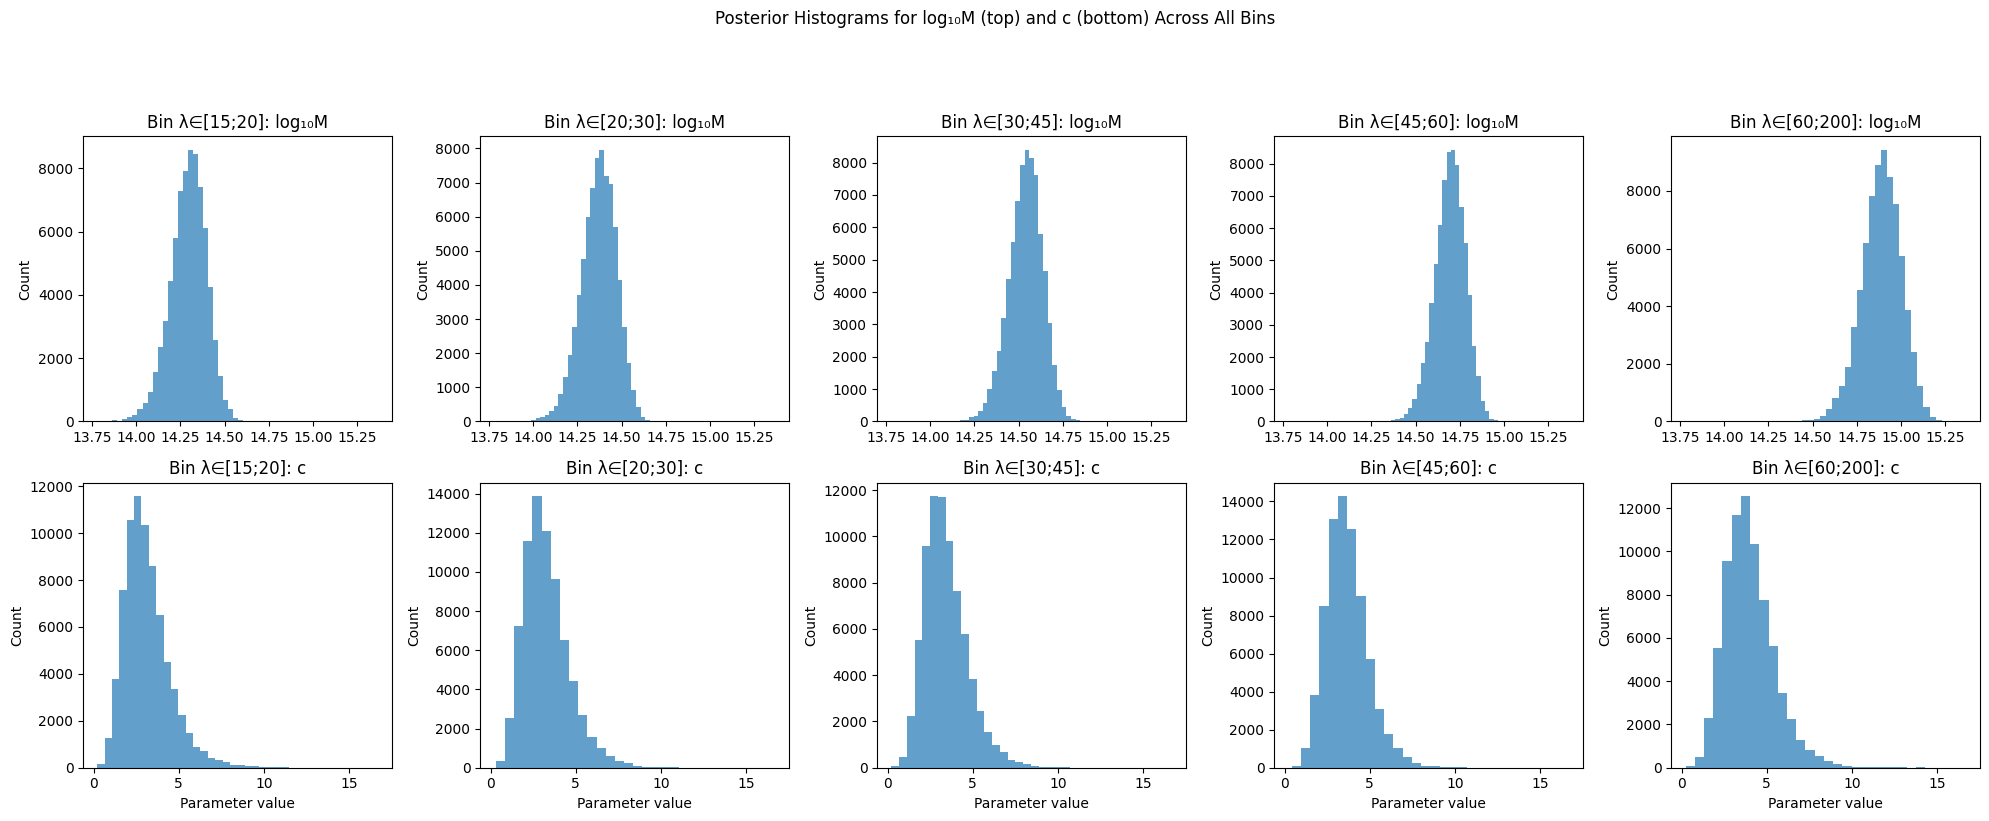

In [35]:

from scipy.optimize import minimize


# --- assume proj_nfw_sigma, compute_rs, compute_rhos, RHOUN, 
#     lambda_edges, mean_sigmas, mean_z, R are already defined ---

# 1) Load the covariance arrays
cov_all = np.load("Sigma-cov.npy")   # shape (5, N_R, N_R)

# 2) Priors and likelihood factory
def log_prior(theta):
    logM, c = theta
    return 0.0 if (13 < logM < 16 and 0.2 < c < 20) else -np.inf

def make_log_like(R, Σ_data, invC, zbin):
    def log_L(theta):
        logM, c = theta
        M       = 10**logM
        Σ_mod   = proj_nfw_sigma(R, M, c, z=zbin)
        Δ       = Σ_data - Σ_mod
        return -0.5 * Δ.dot(invC).dot(Δ)
    return log_L

# 3) MCMC settings
n_bins   = len(lambda_edges) - 1
nwalkers = 50
ndim     = 2
nsteps   = 2000
burnin   = 500

records      = []
samples_list = []

for i in range(n_bins):
    # a) data for this bin
    Σ_data = mean_sigmas[i]
    invC    = np.linalg.inv(cov_all[i])
    zbin    = mean_z[i]

    # b) build posterior
    log_L = make_log_like(R, Σ_data, invC, zbin)
    def log_prob(theta):
        lp = log_prior(theta)
        return lp + log_L(theta) if np.isfinite(lp) else -np.inf

    # c) find a local MAP starting from a rough guess
    init_guess = np.array([ np.log10(1e14), 5.0 ])  # or use your previous medians
    def neg_log_post(theta):
        lp = log_prior(theta)
        return np.inf if not np.isfinite(lp) else - (lp + log_L(theta))

    soln = minimize(neg_log_post, init_guess, method="Nelder-Mead")
    map_logM, map_c = soln.x

    # d) initialize walkers around MAP
    pos = soln.x + 1e-1 * np.random.randn(nwalkers, ndim)

    # e) run the ensemble sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
    sampler.run_mcmc(pos, nsteps, progress=True)

    # f) flatten after burn‐in
    samples = sampler.get_chain(discard=burnin, flat=True)
    samples_list.append(samples)

    # g) compute median ±1σ
    logM_med, c_med         = np.median(samples, axis=0)
    logM_lo, logM_hi        = np.percentile(samples[:, 0], [16, 84])
    c_lo, c_hi              = np.percentile(samples[:, 1], [16, 84])

    records.append({
        "lambda_min":  lambda_edges[i],
        "lambda_max":  lambda_edges[i+1],
        "z_mean":      zbin,
        "log10M_map":  map_logM,
        "c_map":       map_c,
        "log10M_med":  logM_med,
        "log10M_lo16": logM_lo,
        "log10M_hi84": logM_hi,
        "c_med":       c_med,
        "c_lo16":      c_lo,
        "c_hi84":      c_hi,
    })

# 4) save fit results
df = pd.DataFrame(records)
df.to_csv("fit_results_with_map.csv", index=False)


# 5) plot posterior histograms for all bins
fig, axes = plt.subplots(2, n_bins, figsize=(4*n_bins, 8), sharex='row')

for i in range(n_bins):
    samps = samples_list[i]

    # top: log₁₀M
    axes[0, i].hist(samps[:, 0], bins=30, alpha=0.7)
    axes[0, i].set_title(f'Bin λ∈[{lambda_edges[i]};{lambda_edges[i+1]}]: log₁₀M')
    axes[0, i].set_ylabel('Count')

    # bottom: c
    axes[1, i].hist(samps[:, 1], bins=30, alpha=0.7)
    axes[1, i].set_title(f'Bin λ∈[{lambda_edges[i]};{lambda_edges[i+1]}]: c')
    axes[1, i].set_ylabel('Count')
    axes[1, i].set_xlabel('Parameter value')

fig.suptitle('Posterior Histograms for log₁₀M (top) and c (bottom) Across All Bins', y=1.02)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


## Parte D – Analisi finale delle catene MCMC

In questa fase partiamo dalle catene campionate in **Parte C** e,
per ogni bin di ricchezza λ, ricaviamo i parametri best-fit, le incertezze
e alcune diagnostiche di bontà del fit.

---

### 1&nbsp;&nbsp;Estrazione delle statistiche principali

* **Best-fit** – il campione con log-posterior massimo.  
* **Mediana** e **σ** – momenti della distribuzione campionata  
  (deviazione standard come stima dell’errore a 1σ).

---

### 2&nbsp;&nbsp;Corner plot dei posteriori

Per visualizzare la distribuzione congiunta di $(\log_{10}M,\;c)$
utilizziamo un diagramma a triangolo che mostra:

* le proiezioni 1-D (istogrammi) di ciascun parametro;
* le contour 2-D al 68 % e 95 %.

---

### 3&nbsp;&nbsp;Calcolo di χ² e χ² ridotto

Per il profilo teorico NFW ai parametri best-fit
si definiscono i residui

$$
\Delta_i = \Sigma_{\text{mod}}(R_i) \;-\;
           \Sigma_{\text{data}}(R_i)
$$

e si valuta il test chi-quadrato

$$
\chi^{2} \;=\;
\sum_{i}\frac{\Delta_i^{2}}{\sigma_i^{2}},\qquad

$$

---

### 4&nbsp;&nbsp;Posterior-predictive χ²

Estraiamo 100 campioni casuali dalla catena e,
per ciascuno, calcoliamo lo stesso $\chi^{2}$.
Dai 100 valori otteniamo i percentili 16 / 50 / 84 %,
fornendo un intervallo atteso sotto il modello.

---

### 5&nbsp;&nbsp;Output

Per ogni bin salviamo:

| Quantità | Descrizione |
|----------|-------------|
| `best_logM10`, `best_c` | parametri best-fit |
| `err_logM10`, `err_c`   | errore 1 σ (dev. std. della catena) |
| `chi2`, `chi2_red`      | chi-quadrato e chi-quadrato ridotto |
| `pp16`, `pp50`, `pp84`  | percentili 16/50/84 della distrib. χ²<sub>pp</sub> |

Tutti i risultati sono raccolti nel file **`fits_emcee_full.csv`**
e i corner-plot in PNG, da cui si ricavano le figure riepilogative
per il report finale.


In [38]:
df = pd.read_csv("fit_results.csv")

summary = []
for i in range(len(lambda_edges)-1):
    # 1) pull pre‐computed median & errors
    logM_med = df.loc[i, "log10M_med"]
    logM_lo  = df.loc[i, "log10M_lo16"]
    logM_hi  = df.loc[i, "log10M_hi84"]
    c_med    = df.loc[i, "c_med"]
    c_lo     = df.loc[i, "c_lo16"]
    c_hi     = df.loc[i, "c_hi84"]

    # 2) retrieve the chain & data
    samples = samples_list[i]          # shape (n_samples,2)
    Σ_data  = mean_sigmas[i]
    invC    = np.linalg.inv(cov_all[i])
    zbin    = mean_z[i]

    # 3) compute posterior for each sample and pick MAP
    log_posts = []
    for theta in samples:
        lp = log_prior(theta)
        if not np.isfinite(lp):
            log_posts.append(-np.inf)
        else:
            # recompute only the likelihood part
            log_posts.append(lp + make_log_like(R,Σ_data,invC,zbin)(theta))
    best_idx = np.nanargmax(log_posts)
    logM_bf, c_bf = samples[best_idx]

    # 4) compute χ² at MAP
    Σ_bf = proj_nfw_sigma(R, 10**logM_bf, c_bf, z=zbin)
    Δ    = Σ_data - Σ_bf
    chi2 = float(Δ.dot(invC).dot(Δ))
    dof  = len(R) - 2

    # 5) corner plot of the posterior with MAP marked → save to file
    fig = corner.corner(
    samples,
    labels=[r"$\log_{10}M$", r"$c$"],
    truths=[logM_bf, c_bf],
    truth_color='C1',
    show_titles=True,
    title_fmt=".3f"              # three decimals
)

# bump the suptitle up a bit so it isn't clipped
    fig.suptitle(
        f"Bin λ∈[{lambda_edges[i]},{lambda_edges[i+1]})  ⟨z⟩={zbin:.3f}",
        y=1.02                      # outside the default top margin
    )

    # leave room for the suptitle
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    # save with tight bbox so nothing gets cut
    fig.savefig(f"corner_bin_{i}.png", bbox_inches="tight")
    plt.close(fig)

    # 6) store summary
    summary.append({
        "lambda_min":  lambda_edges[i],
        "lambda_max":  lambda_edges[i+1],
        "z_mean":      zbin,
        "log10M_bf":   logM_bf,
        "c_bf":        c_bf,
        "log10M_med":  logM_med,
        "log10M_lo16": logM_lo,
        "log10M_hi84": logM_hi,
        "c_med":       c_med,
        "c_lo16":      c_lo,
        "c_hi84":      c_hi,
        "chi2":        chi2,
        "dof":         dof
    })

# final table and CSV
dfD = pd.DataFrame(summary)
dfD.to_csv("fit_summary_D.csv", index=False)
print(dfD)


   lambda_min  lambda_max    z_mean  log10M_bf      c_bf  log10M_med  \
0          15          20  0.460090  14.330167  2.684357   14.294315   
1          20          30  0.463887  14.408580  2.802461   14.379877   
2          30          45  0.459208  14.568751  3.067457   14.536711   
3          45          60  0.456439  14.720707  3.315495   14.694682   
4          60         200  0.441161  14.922706  3.576413   14.889600   

   log10M_lo16  log10M_hi84     c_med    c_lo16    c_hi84      chi2  dof  
0    14.189360    14.388072  2.989632  1.944651  4.431658  0.570825    6  
1    14.276436    14.471246  3.082445  2.048730  4.503082  0.457417    6  
2    14.436337    14.625541  3.365383  2.311193  4.702154  0.271871    6  
3    14.605506    14.778088  3.511611  2.489887  4.803237  0.181995    6  
4    14.774287    14.994701  3.838278  2.650063  5.347235  0.068060    6  


**Discussione sul valore di χ²**

Il test chi-quadrato utilizza
$$
\chi^{2} = \sum_i \frac{\bigl[\Sigma_{\text{mod}}(R_i)-\Sigma_{\text{data}}(R_i)\bigr]^2}{\sigma_i^{2}},
\qquad
\sigma_i^{2} = C_{ii}.
$$

Poiché $C_{ii}$ riflette la **dispersione complessiva fra aloni**
(non il solo errore statistico della media)
le $\sigma_i$ sono sovrastimate rispetto all’incertezza sul profilo medio.
I residui $\Delta_i$ risultano quindi molto piccoli in unità di
$\sigma_i$, producendo un χ² “troppo buono” (≪ i gradi di libertà)
anche quando il modello si limita a descrivere la media dei dati.


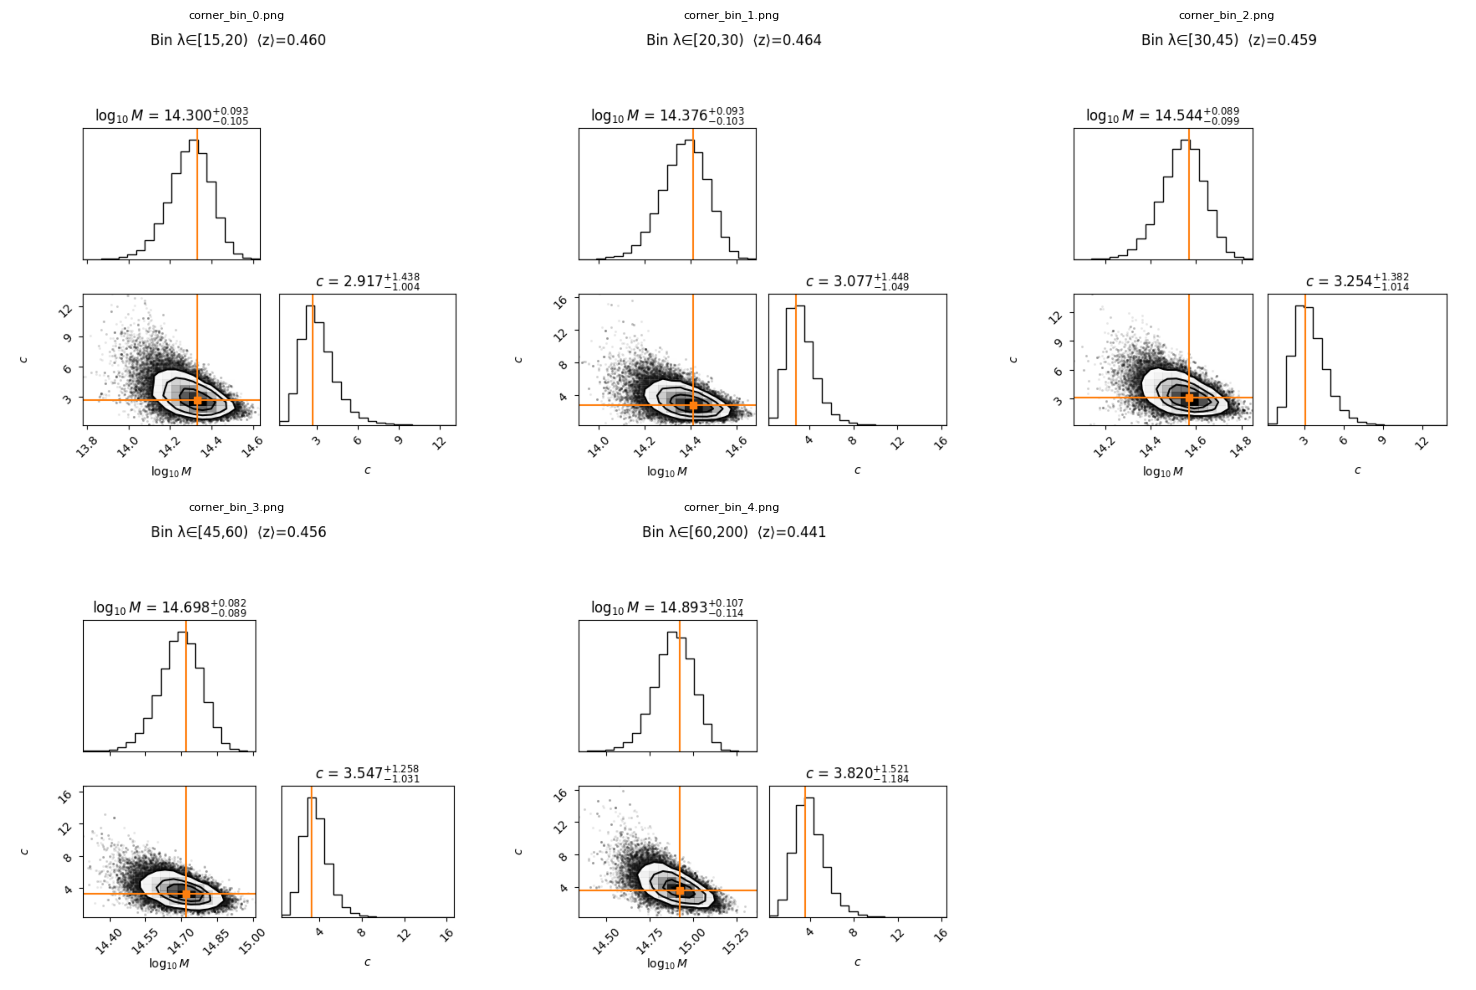

In [39]:
import matplotlib.image as mpimg

# List your five filenames
files = ["corner_bin_0.png", "corner_bin_1.png", "corner_bin_2.png", "corner_bin_3.png", "corner_bin_4.png"]

# Create a grid: e.g. 2 rows × 3 columns (one slot will remain empty)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, fn in zip(axes, files):
    img = mpimg.imread(fn)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(fn, fontsize=8)

# Hide the last empty subplot if any
for ax in axes[len(files):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### Confronto finale: profili simulati vs. modello NFW best-fit

Nell’ultimo grafico tracciamo, per ciascun bin di ricchezza λ:

1. **Punti con barre d’errore**  
   *Coordinate* → raggio $R_i$ (ascissa) e profilo medio  
   $\langle\Sigma_{\text{sim}}(R_i)\rangle$ (ordinata).  
   *Errore verticale* = $\sigma_i / \sqrt{N_{\text{halo}}}$  
   (errore sulla media del profilo).

2. **Linea tratteggiata**: profilo NFW calcolato ai **parametri best-fit**  
   estratti dalla catena MCMC (massimo log-posterior):
   $$
     \bigl(\log_{10}M_{\star},\,c_{\star}\bigr)
     = \arg\max\!\bigl[\ln p(\log_{10}M, c \mid \text{dati})\bigr].
   $$

L’intero layout è un grigliato 3 × 2:
* ogni riquadro mostra un intervallo di λ, indicato nel titolo;  
* assi log-log $(R,\Sigma)$ condivisi;  
* la leggenda riporta i parametri best-fit di quel bin.

Il risultato visivo consente di verificare
quanto il profilo teorico (linea arancione) descriva
i dati medi (punti blu) lungo tutti gli ordini di grandezza
in raggio e superficie di massa.


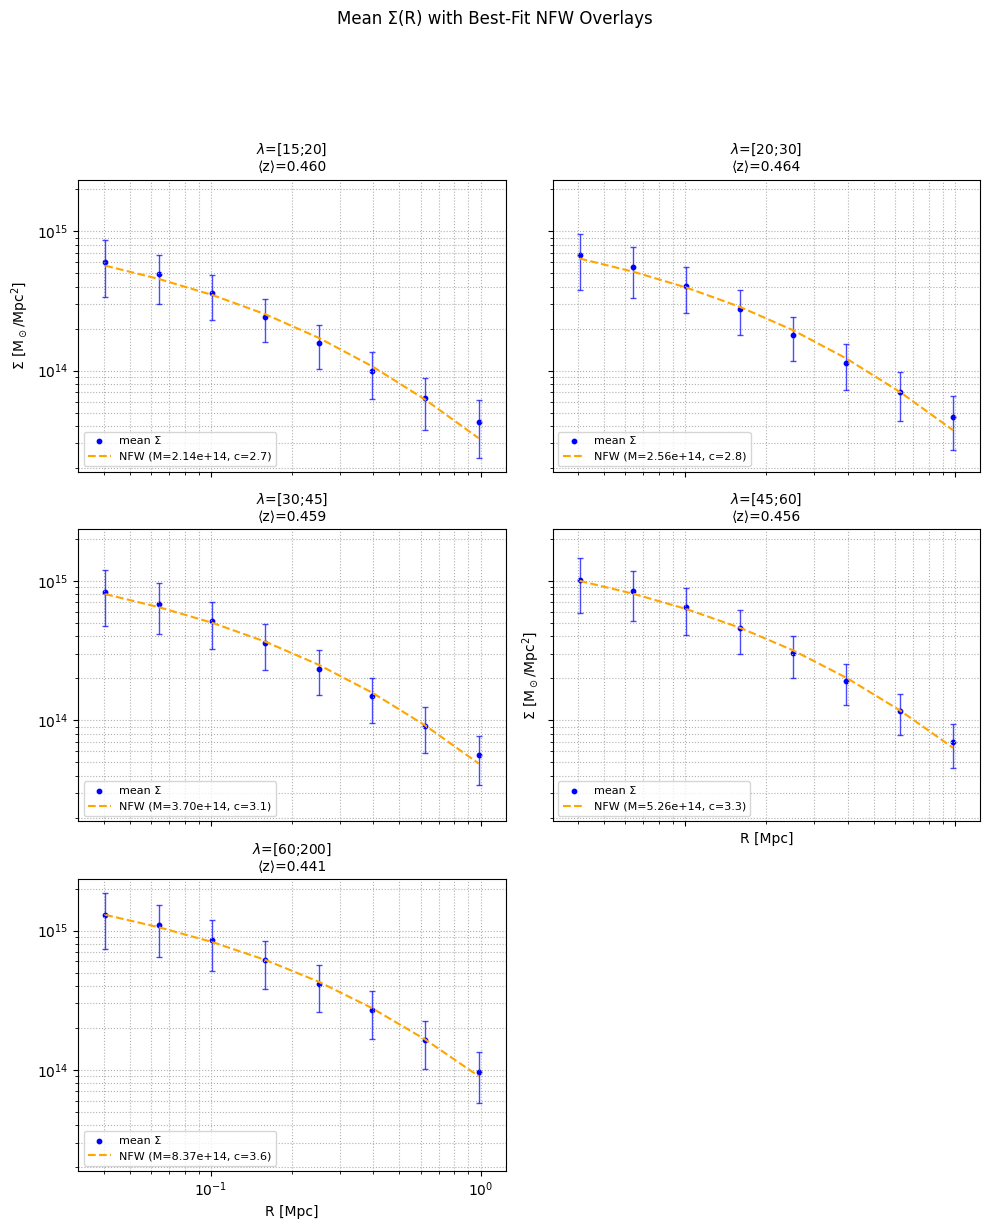

In [41]:

# prepare figure: 2×3 grid, last panel empty, less stretched
fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=True)
axes = axes.flatten()

# add some space between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, ax in enumerate(axes):
    if i >= len(mean_sigmas):
        ax.axis('off')
        continue

    # data + 1σ ribbon
    μ = mean_sigmas[i]
    σ = std_sigmas[i]
    zbar = mean_z[i]
    ax.scatter(R, μ, s=10, color='blue', label="mean Σ")
    ax.errorbar(R, μ, yerr=σ, fmt='none', ecolor='blue', elinewidth=1, capsize=2, alpha=0.7)

    # best-fit parameters for this bin
    row = dfD.iloc[i]
    M_bf = 10**row["log10M_bf"]
    c_bf = row["c_bf"]

    # model curve
    Σ_bf = proj_nfw_sigma(R, M_bf, c_bf, z=zbar)
    ax.plot(
        R, Σ_bf, '--',
        color='orange',
        lw=1.5,
        label=rf"NFW (M={M_bf:.2e}, c={c_bf:.1f})"
    )

    # formatting
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)
    ax.grid(True, which='both', ls=':')
    ax.set_title(
        rf"$\lambda$=[{int(row['lambda_min'])};{int(row['lambda_max'])}]" 
        + "\n" + rf"⟨z⟩={row['z_mean']:.3f}",
        fontsize=10
    )
    if i % 3 == 0:
        ax.set_ylabel(r"$\Sigma$ [M$_\odot$/Mpc$^2$]")
    if i // 3 == 1:
        ax.set_xlabel("R [Mpc]")

    ax.legend(fontsize=8, loc='lower left')

fig.suptitle("Mean Σ(R) with Best-Fit NFW Overlays", y=1.02)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
